In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from category_encoders import MEstimateEncoder
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_log_error

In [2]:
import tensorflow as tf
import keras

print(f"Tensorflow version: {tf.__version__}")
# tf.config.set_visible_devices([],"GPU")
for device in tf.config.get_visible_devices():
    print(f"{device[0]} is avalible.")


Tensorflow version: 2.15.0
/physical_device:CPU:0 is avalible.


In [3]:
# Regression 1 Dens ~ 0.76
# DL model ~ 0.75
# xgbr ~ 0.74

In [4]:
train_data_path = "train.csv"
raw_data = pd.read_csv(train_data_path)
test_data_path = "test.csv"
raw_test = pd.read_csv(test_data_path)

In [5]:
print(raw_test.isna().sum())
raw_test.set_index("id",inplace=True)
raw_test.head()


id                           0
Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
id,,,,,,,,,,,
378428,FDP45,15.70,Low Fat,0.074779,Snack Foods,256.1014,OUT049,1999,Medium,Tier 1,Supermarket Type1
378429,FDY44,14.15,Regular,0.024821,Fruits and Vegetables,196.4110,OUT017,2007,Medium,Tier 2,Supermarket Type1
378430,NCV29,11.80,LF,0.032813,Health and Hygiene,177.6686,OUT013,1987,High,Tier 3,Supermarket Type1
378431,FDG53,10.00,Low Fat,0.087646,Frozen Foods,138.6838,OUT017,2007,Medium,Tier 2,Supermarket Type1
378432,NCB18,19.60,Low Fat,0.000000,Household,89.7514,OUT049,1999,Medium,Tier 1,Supermarket Type1


In [6]:
out_id = pd.Series(raw_test.index)
out_id.head()

0    378428
1    378429
2    378430
3    378431
4    378432
Name: id, dtype: int64

In [7]:
print(raw_data.shape)
# print(raw_data.loc[raw_data.isna().any(axis=1)])
raw_data.dropna(inplace=True)
raw_data.set_index("id",inplace=True)
raw_x = raw_data.copy().sample(frac=1,random_state=2111)
raw_y = raw_x.pop("Item_Outlet_Sales")
print(raw_x.shape)

(377566, 13)
(377564, 11)


In [8]:
real_feachures = [column for column in raw_x if raw_x[column].dtype == "float64"]
class_feachures = [column for column in raw_x if raw_x[column].dtype == "object"]


In [9]:
raw_y.describe()

count    377564.000000
mean       2125.332007
std        1667.881263
min          33.290000
25%         965.410000
50%        1752.385600
75%        2878.253400
max       31224.726950
Name: Item_Outlet_Sales, dtype: float64

In [10]:
raw_x[real_feachures].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,377564.000000,377564.000000,377564.000000,377564.000000
mean,12.801150,0.054543,137.769239,2000.663903
std,4.618502,0.046881,60.977105,6.518278
min,4.555000,0.000000,31.290000,1985.000000
25%,8.775000,0.017429,92.946200,1997.000000
50%,12.500000,0.044917,131.131000,2002.000000
75%,16.750000,0.081413,182.263400,2007.000000
max,30.000000,0.328391,266.888400,2009.000000


In [11]:
raw_x[class_feachures].describe()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,377564,377564,377564,377564,377564,377564,377564
unique,1559,5,16,10,3,3,4
top,FDU20,Low Fat,Snack Foods,OUT045,Medium,Tier 2,Supermarket Type1
freq,468,235693,59614,54578,173995,160412,304364


In [12]:
def print_rating(x,y):
    mi_x = x.copy()
    # for column in mi_x[class_feachures]:
    #     mi_x[column],_ = mi_x[column].factorize()
    discrete_features = mi_x.dtypes == int
    # print(discrete_features)
    rating = pd.Series(mutual_info_regression(mi_x, y, discrete_features=discrete_features),index=mi_x.columns).sort_values(ascending=False)
    print(rating)

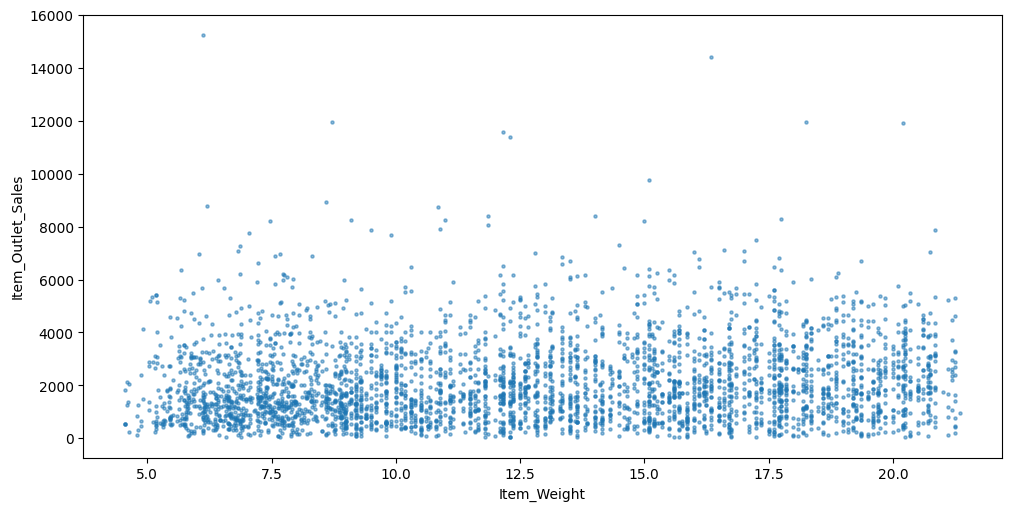

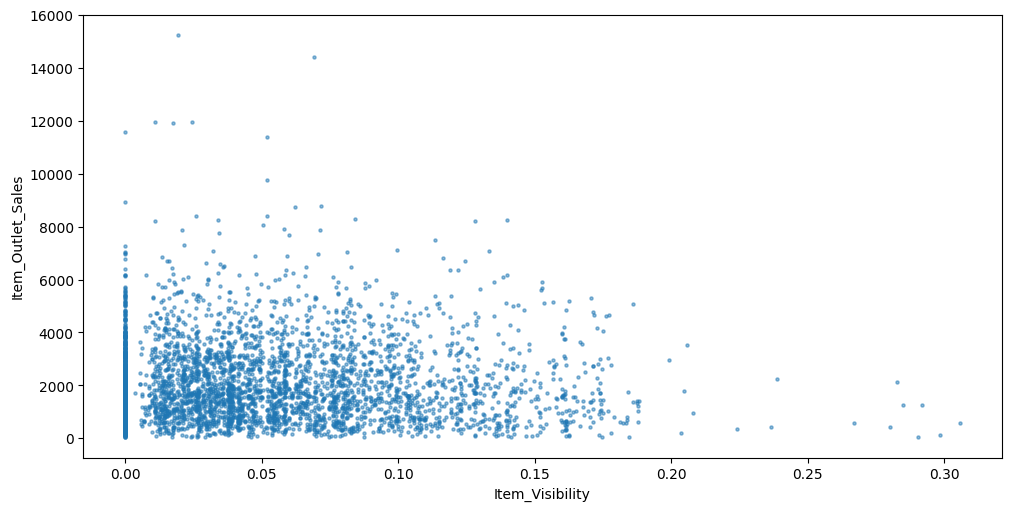

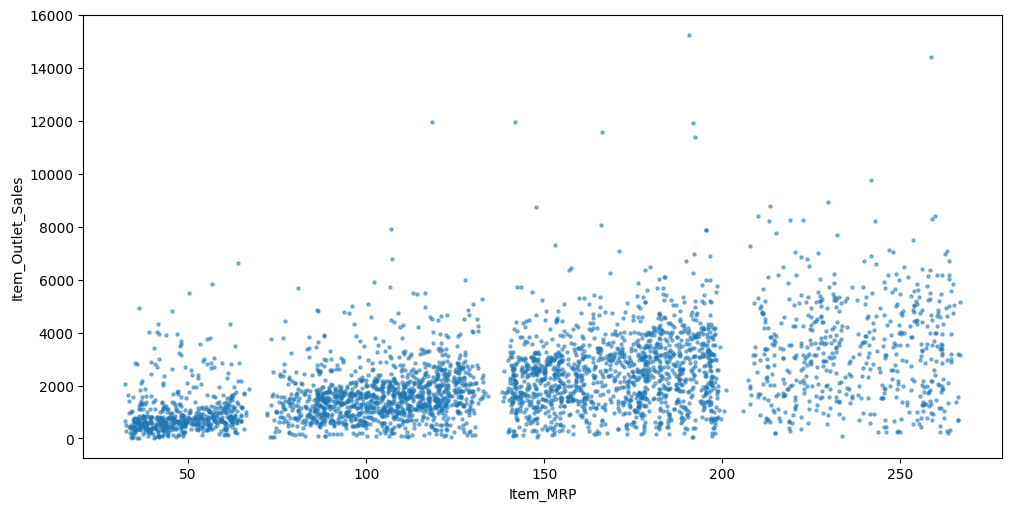

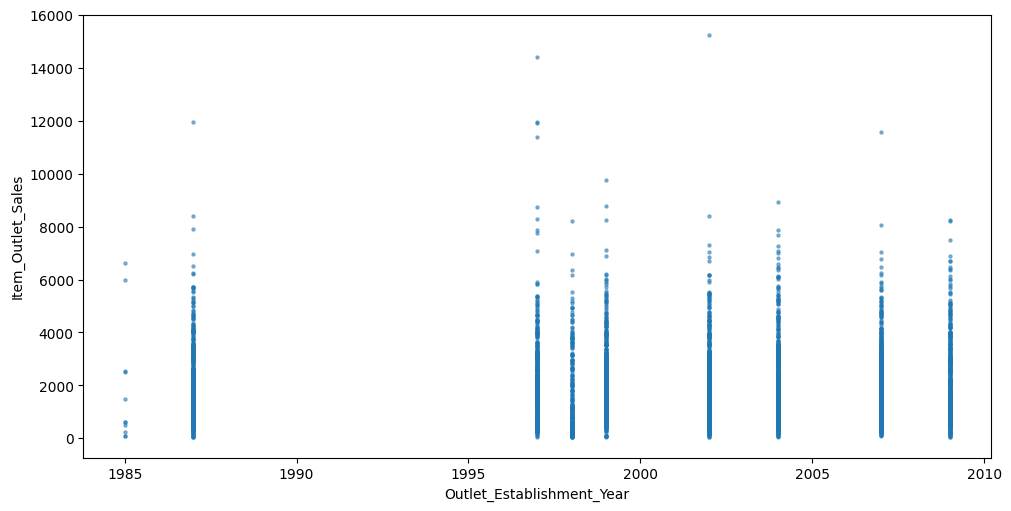

In [13]:
for i, column in enumerate(raw_x[real_feachures]):
    fig,ax=plt.subplots(figsize=(10,5), layout='constrained')
    ax.set_ylabel(raw_y.name)
    ax.set_xlabel(column)
    ax.scatter(raw_x.loc[::100,column],
               raw_y[::100],
               s=5,
               alpha=0.5)


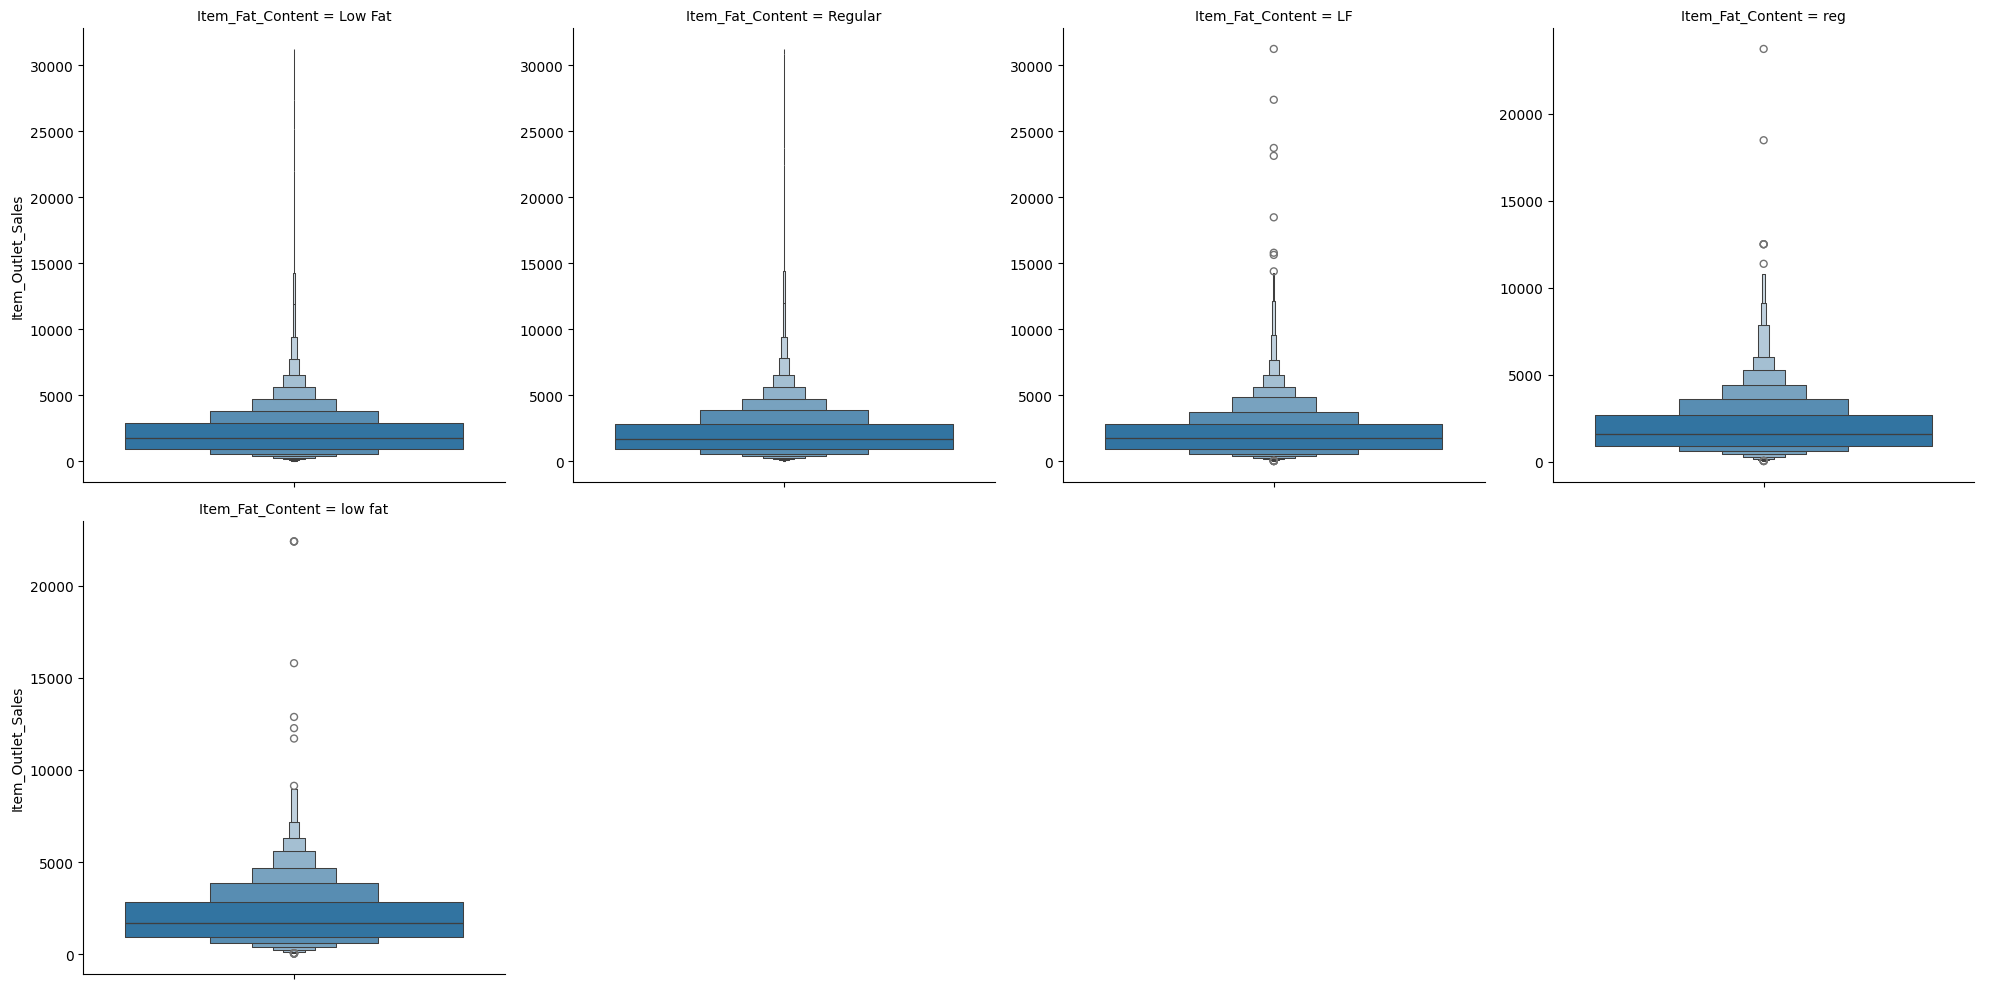

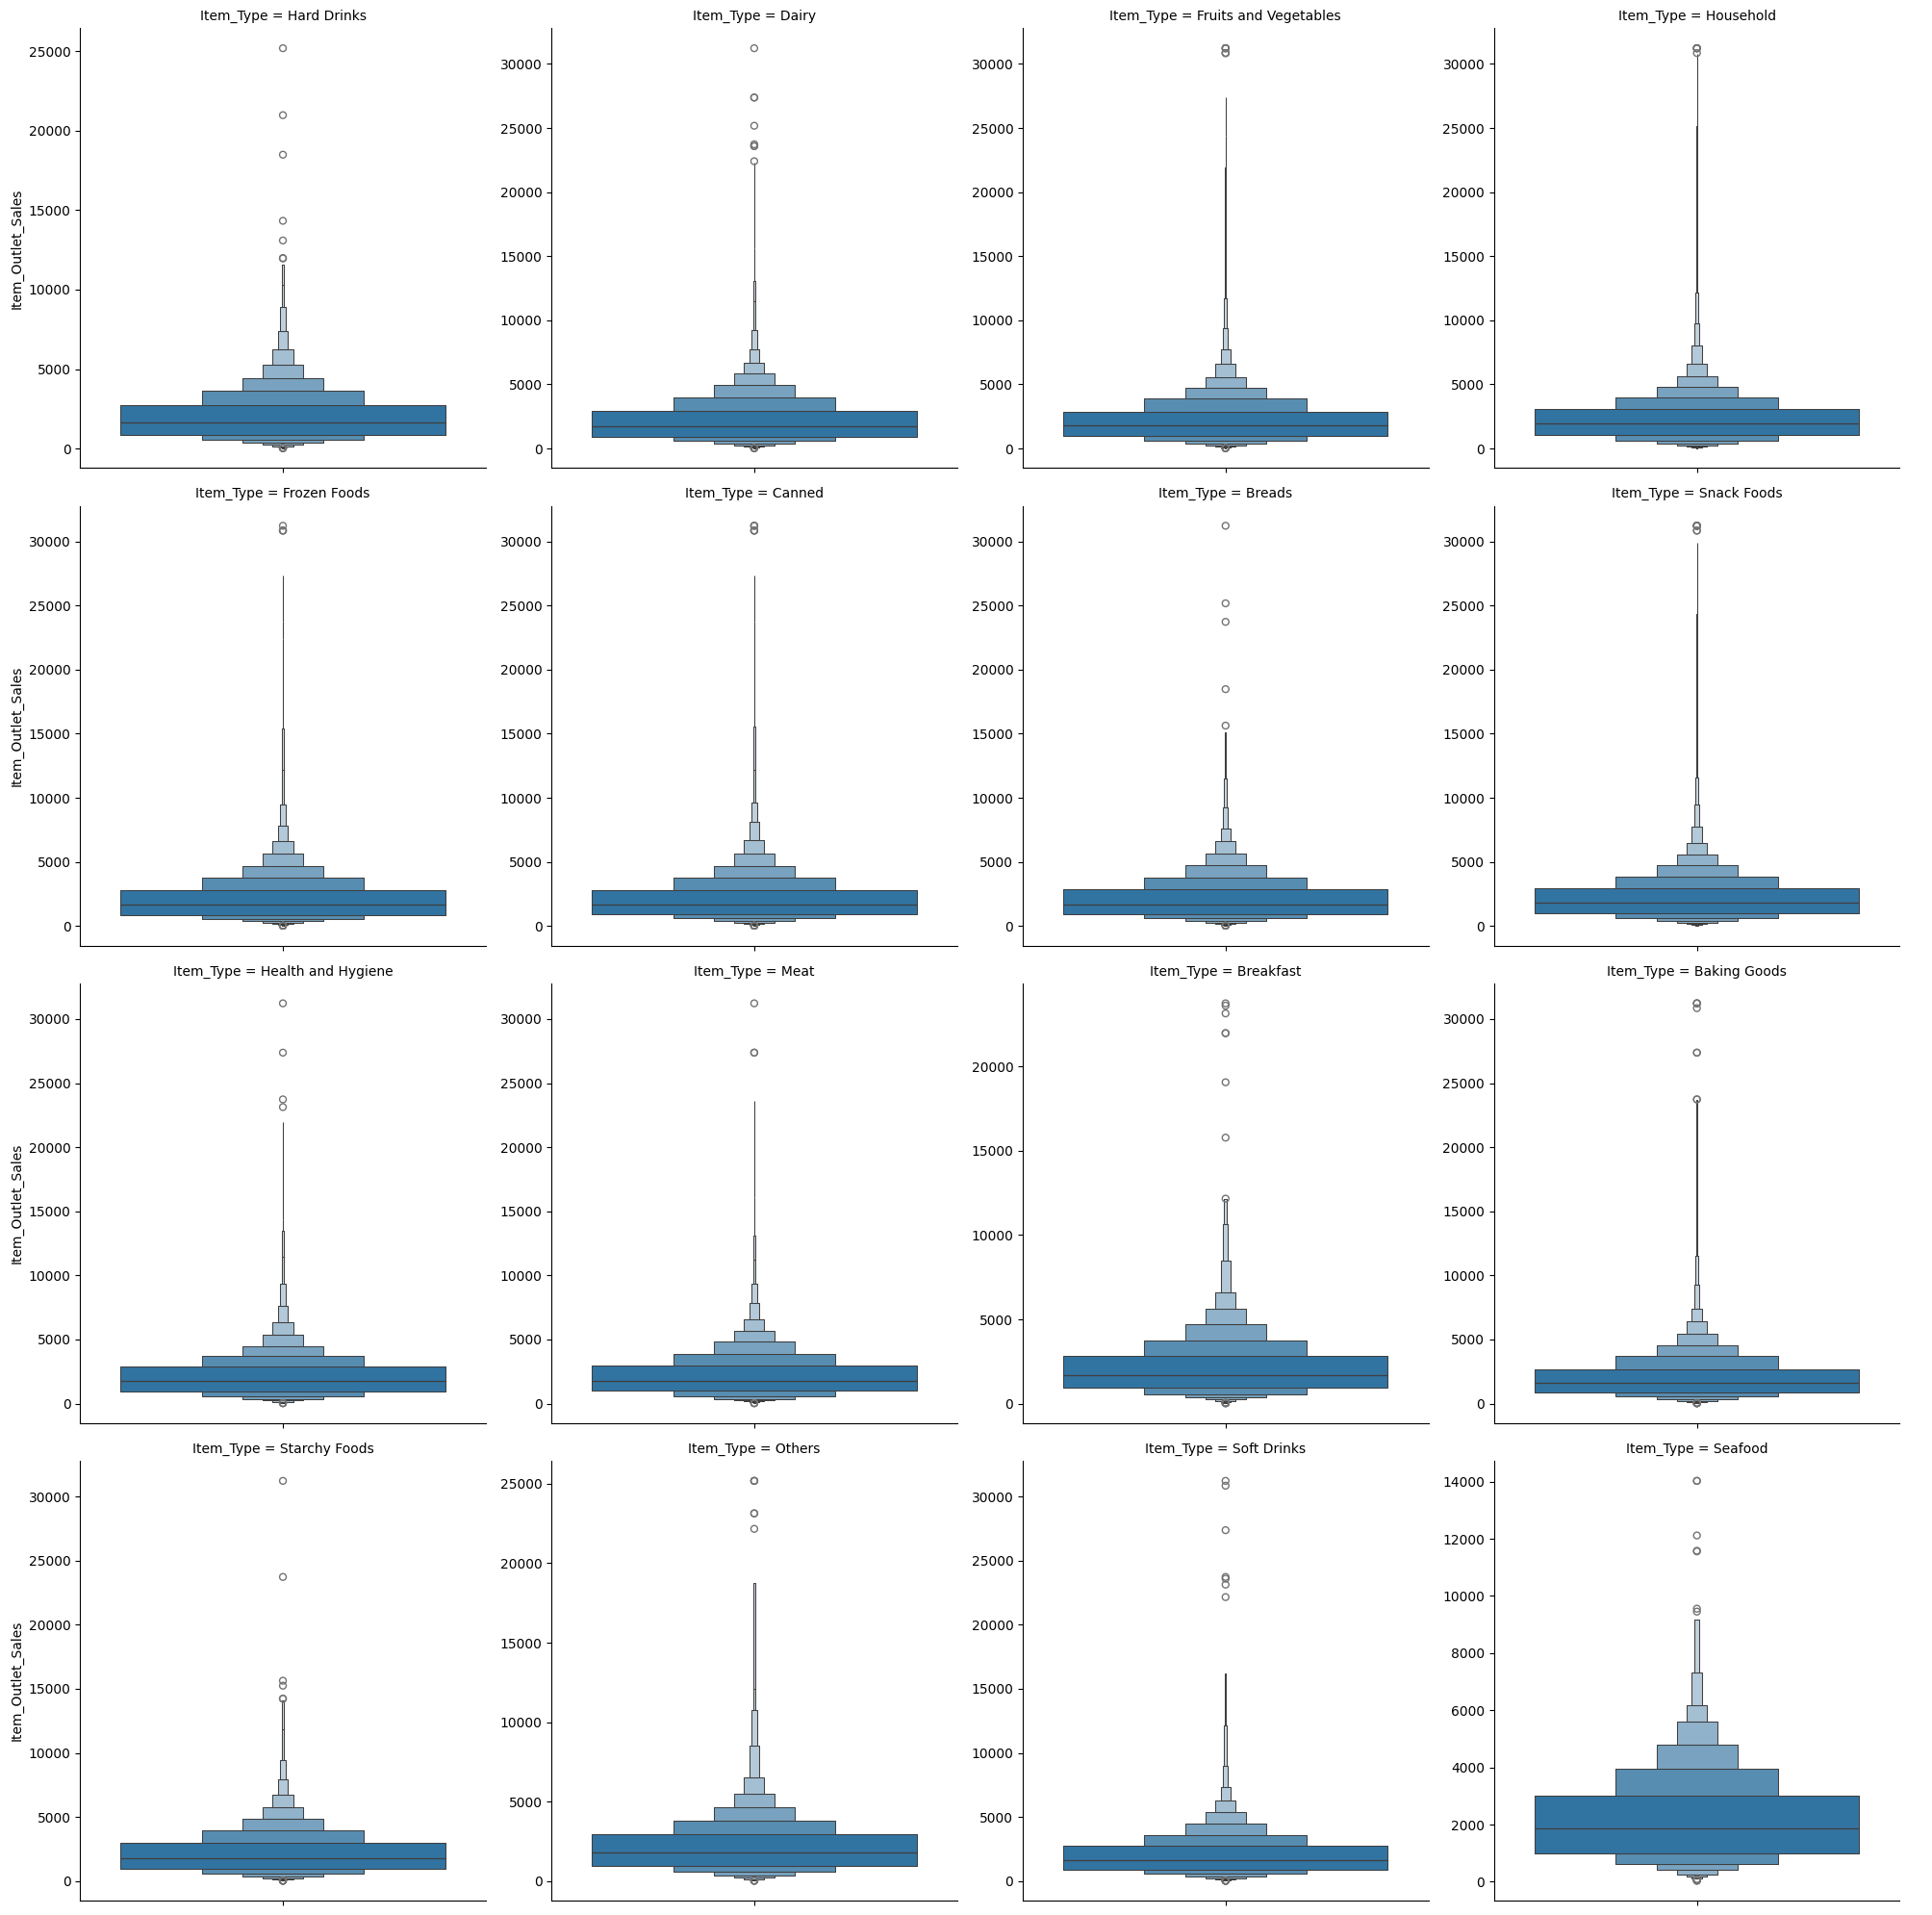

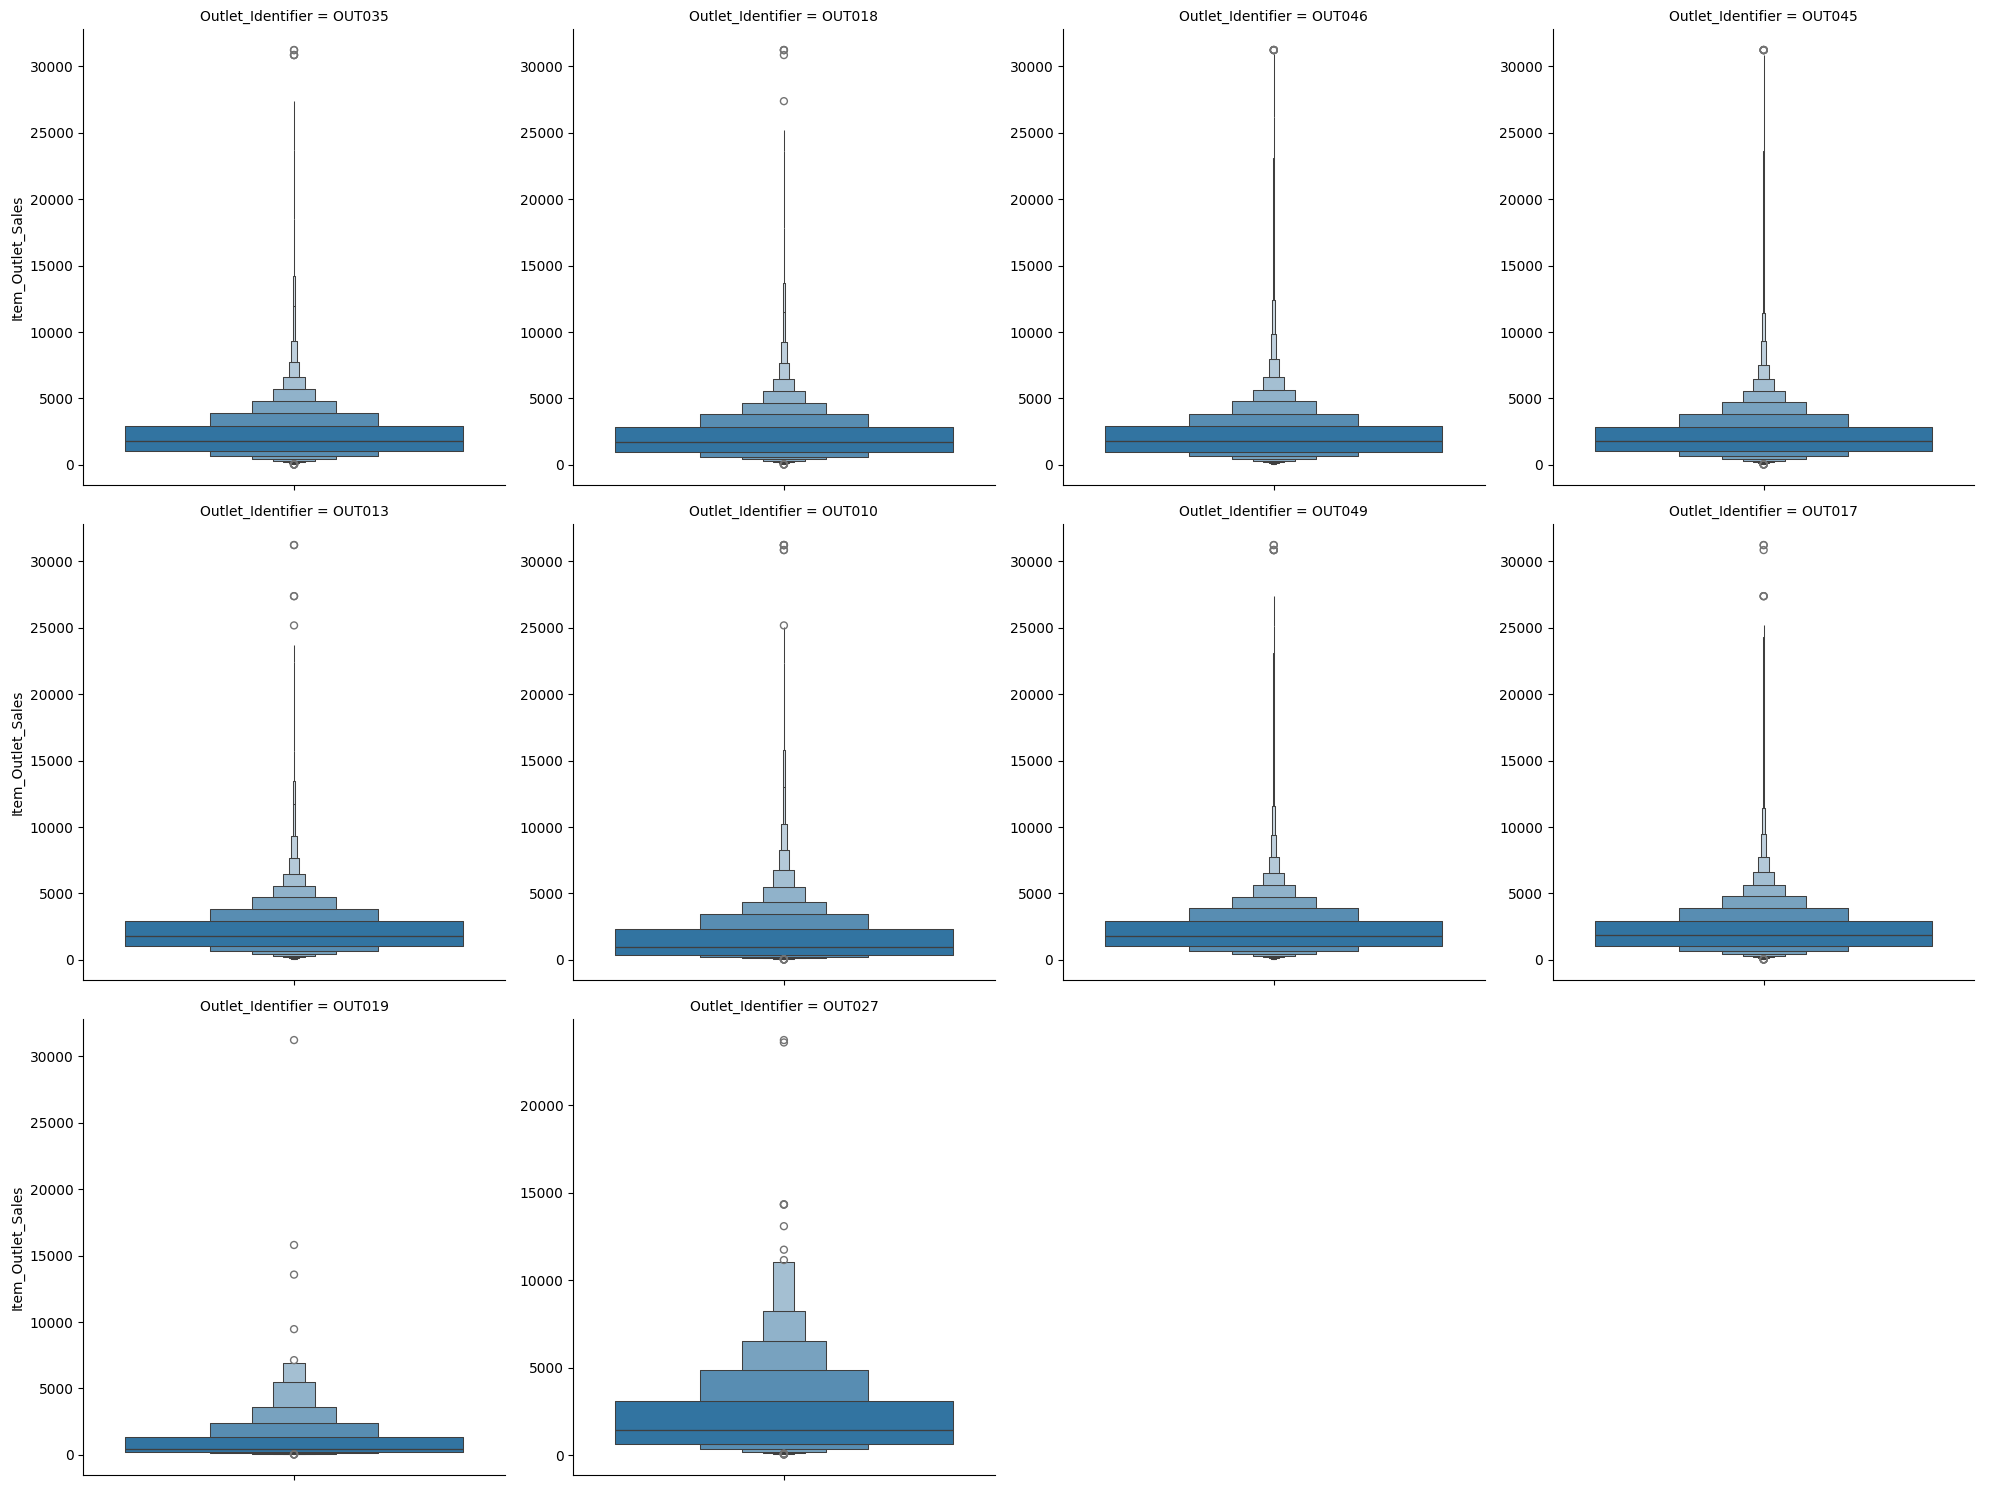

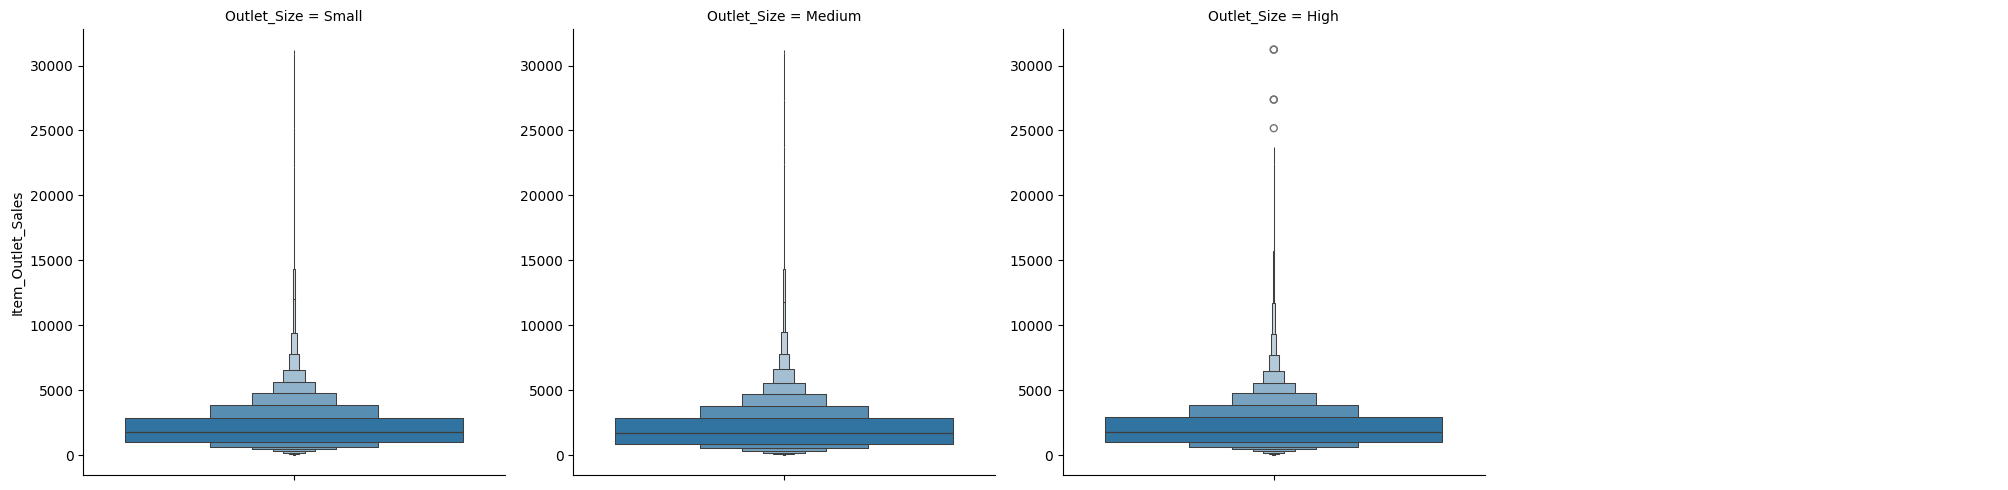

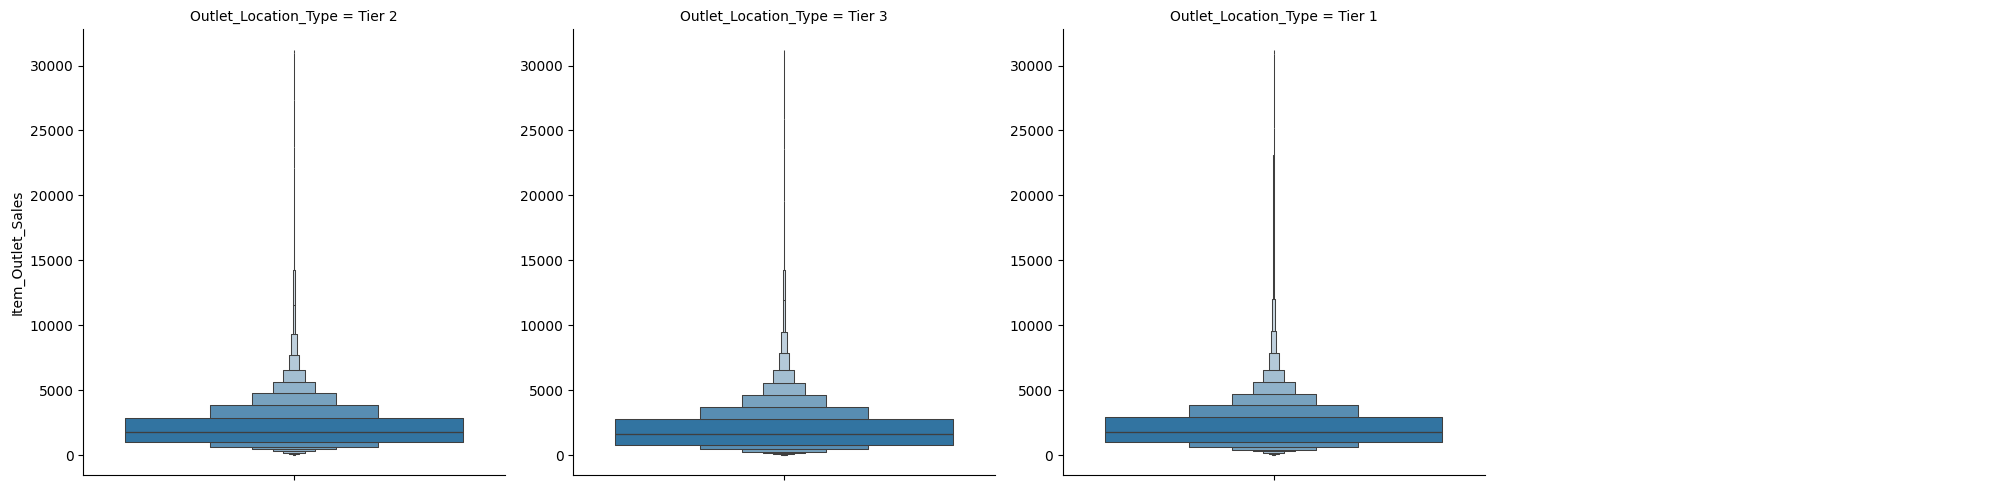

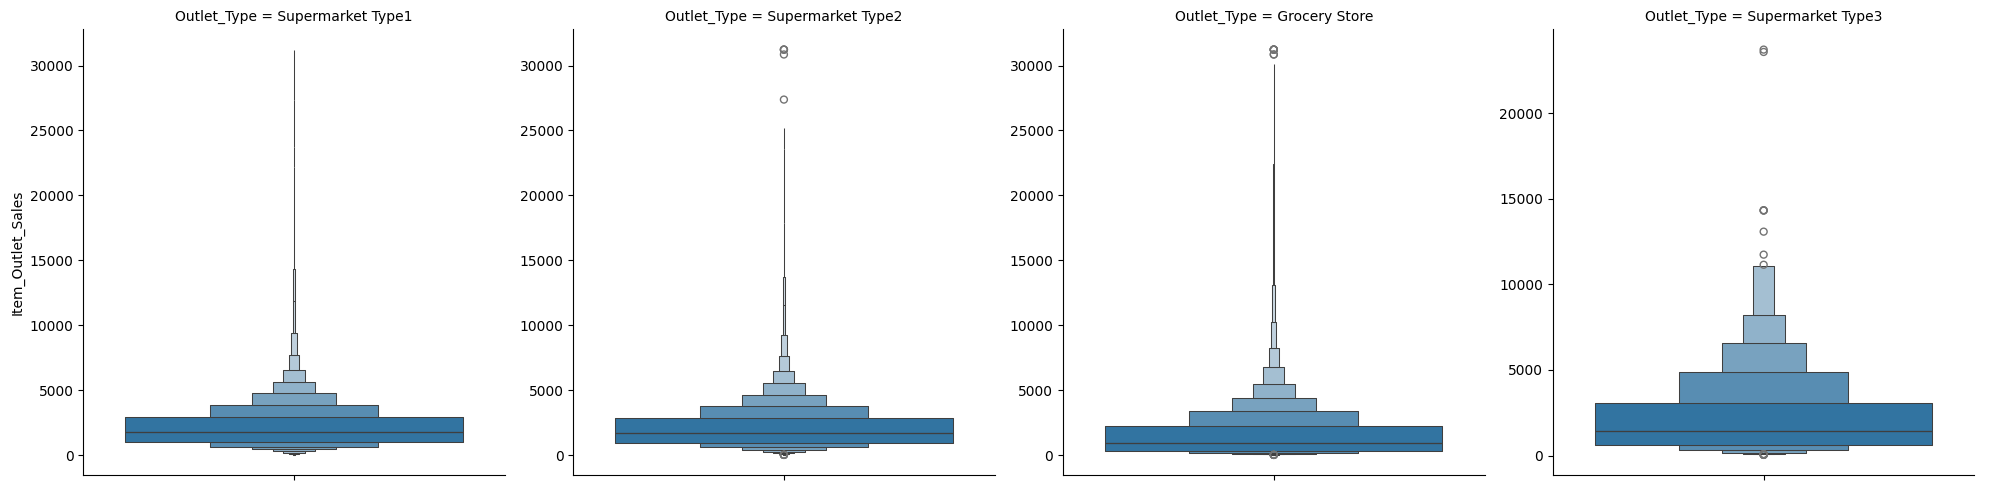

In [14]:
for i, column in enumerate(raw_x[class_feachures]):
    # fig,ax=plt.subplots(figsize=(10,5), layout='constrained')
    # ax.set_ylabel(raw_y.name)
    # ax.set_xlabel(column)
    # ax.scatter(raw_x.loc[::100,column],
    #            raw_y[::100],
    #            s=5,
    #            alpha=0.5)
    if column == "Item_Identifier":
        continue
    sns.catplot(
    y="Item_Outlet_Sales",
    col=column,
    data= {column : raw_x[column],"Item_Outlet_Sales":raw_y},
    kind='boxen',
    sharey=False,
    col_wrap=4,
    )
    # break

In [15]:
frac_to_split = int(0.2*len(raw_x))
print(frac_to_split)
x_encode, y_encode = raw_x.iloc[:frac_to_split], raw_y.iloc[:frac_to_split]
raw_x, raw_y = raw_x.iloc[frac_to_split:], raw_y.iloc[frac_to_split:]

75512


In [16]:
encoder = MEstimateEncoder(cols=['Item_Identifier'], m=5)
encoder.fit(x_encode, y_encode)
raw_x = encoder.transform(raw_x)
raw_test = encoder.transform(raw_test)
raw_x.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
id,,,,,,,,,,,
21848,2196.209849,6.30,Low Fat,0.000000,Canned,179.1660,OUT049,1999.0,Medium,Tier 1,Supermarket Type1
310829,2610.115663,15.85,Regular,0.062213,Breads,218.3166,OUT046,1997.0,Small,Tier 1,Supermarket Type1
160887,2076.041430,17.75,Regular,0.029822,Fruits and Vegetables,139.9838,OUT045,2002.0,Small,Tier 2,Supermarket Type1
65953,1773.997635,20.50,Low Fat,0.143574,Household,35.4190,OUT045,2002.0,Small,Tier 2,Supermarket Type1
235232,1948.818879,9.10,Low Fat,0.033803,Baking Goods,263.1910,OUT013,1987.0,High,Tier 3,Supermarket Type1


In [17]:

frac_to_split = int(0.8*len(raw_x))
print(frac_to_split)
raw_x_train, y_train = raw_x.iloc[:frac_to_split], raw_y.iloc[:frac_to_split]
raw_x_val, y_val = raw_x.iloc[frac_to_split:], raw_y.iloc[frac_to_split:]

241641


In [18]:
x_train = pd.DataFrame()
x_val = pd.DataFrame()
x_test = pd.DataFrame()
real_feachures = [
    'Item_Weight',              # ++
    'Item_Visibility',          # ++
    'Item_MRP',                 # ++++
    'Outlet_Establishment_Year', # ++
    'Item_Identifier',          # ++
    ]
class_feachures = [
    'Item_Fat_Content',     # -?
    'Item_Type',            # +
    'Outlet_Identifier',    # +
    'Outlet_Size',          # +
    'Outlet_Location_Type',  # +
    'Outlet_Type'           # +     
    ]


In [19]:
for column in real_feachures:
    print(column, ". Start normalization.")
    mean = raw_x_train[column].mean()
    std = raw_x_train[column].std()
    x_train[column] = raw_x_train[column].map(lambda x: (x-mean)/std)
    x_val[column] = raw_x_val[column].map(lambda x: (x-mean)/std)
    x_test[column] = raw_test[column].map(lambda x: (x-mean)/std)
    # x_dl[column] = raw_x[column].map(lambda x: x)
    print(column, ". End normalization.")
x_train.head()

Item_Weight . Start normalization.
Item_Weight . End normalization.
Item_Visibility . Start normalization.
Item_Visibility . End normalization.
Item_MRP . Start normalization.
Item_MRP . End normalization.
Outlet_Establishment_Year . Start normalization.
Outlet_Establishment_Year . End normalization.
Item_Identifier . Start normalization.
Item_Identifier . End normalization.


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier
id,,,,,
21848,-1.405100,-1.163357,0.681000,-0.255130,0.156699
310829,0.661196,0.165946,1.323823,-0.561545,1.103297
160887,1.072291,-0.526156,0.037658,0.204492,-0.118125
65953,1.667298,1.904402,-1.679215,0.204492,-0.808895
235232,-0.799275,-0.441093,2.060626,-2.093618,-0.409081


In [20]:
# kmeans = KMeans(n_clusters=10, n_init=50, random_state=0)
# x_train["Claster"] = kmeans.fit_predict(x_train[real_feachures])
# # del x_train["Item_MRP"]
# x_val["Claster"] = kmeans.predict(x_val[real_feachures])
# # del x_val["Item_MRP"]
# x_train.head()

In [21]:
for column in class_feachures:
#     print(column, ". Start convertin to OneHot")
#     x_dl = pd.concat([x_dl, pd.get_dummies(raw_x[column], prefix=column)], axis=1)
#     print(column, ". End convertin to OneHot")
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(raw_x_train[[column]]))
    OH_cols_valid = pd.DataFrame(OH_encoder.transform(raw_x_val[[column]]))
    OH_cols_test = pd.DataFrame(OH_encoder.transform(raw_test[[column]]))
    OH_cols_train.index = raw_x_train.index
    OH_cols_valid.index = raw_x_val.index
    OH_cols_test.index = raw_test.index
    OH_cols_train.columns = column+"_"+OH_cols_train.columns.astype(str)
    OH_cols_valid.columns = column+"_"+OH_cols_valid.columns.astype(str)
    OH_cols_test.columns = column+"_"+OH_cols_test.columns.astype(str)
    x_train = pd.concat([x_train, OH_cols_train],axis=1).astype("float32")
    x_val = pd.concat([x_val, OH_cols_valid],axis=1).astype("float32")
    x_test = pd.concat([x_test, OH_cols_test],axis=1).astype("float32")
    
print(x_train.shape,x_val.shape)

(241641, 46) (60411, 46)


In [22]:
# print_rating(x_train,y_train)

In [23]:
def rmsle(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    first_log = tf.math.log(keras.backend.maximum(y_pred, keras.backend.epsilon()) + 1.0)
    second_log = tf.math.log(keras.backend.maximum(y_true, keras.backend.epsilon()) + 1.0)
    aaa = keras.backend.mean(tf.math.squared_difference(first_log, second_log) , axis=-1)
    # print(aaa)
    batch_msle = keras.backend.mean(aaa)
    # print(batch_msle)
    return keras.backend.sqrt(batch_msle)

def x_rmsle(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    first_log = tf.math.log(keras.backend.maximum(y_pred, keras.backend.epsilon()) + 1.0)
    second_log = tf.math.log(keras.backend.maximum(y_true, keras.backend.epsilon()) + 1.0)
    batch_msle = keras.backend.mean(tf.math.squared_difference(first_log, second_log) , axis=-1)
    return keras.backend.mean(keras.backend.sqrt(batch_msle))
# class RootMeanSquaredLogarithmicError(keras.base_metric.MeanMetricWrapper):
#     def __init__(self, name="mean_squared_logarithmic_error", dtype=None):
#             super().__init__(root_mean_squared_logarithmic_error, name, dtype=dtype)


# my_msle = keras.metrics.MeanSquaredLogarithmicError(name="mymsle")
# # @tf.function
# def my_rmsle(y_true,y_pred):

#     return my_msle(y_true,y_pred)
# print(my_msle(tf.constant([4,5,53,63,7,8,4]),tf.constant([1,10,1,1,1,1,1])))
# print(my_rmsle(tf.constant([4,5,53,63,7,8,4]),tf.constant([1,10,1,1,1,1,1])))

In [24]:
def gradient(predt, dtrain):
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt, dtrain):
    # print(predt,dtrain)
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) / np.power(predt + 1, 2))

def squared_log(predt, dtrain):
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

In [66]:
xgb_raw_model = xgb.train({'tree_method': 'hist', 'seed': 0},  
           dtrain=xgb.DMatrix(x_train, label=y_train),
           num_boost_round=200,
            evals=[(xgb.DMatrix(x_val, label=y_val),"msle")],
                          early_stopping_rounds=3,
            # verbose_eval=0,
           # obj=squared_log,
                         )


[0]	msle-rmse:1555.48725
[1]	msle-rmse:1499.54861
[2]	msle-rmse:1470.72438
[3]	msle-rmse:1455.12202
[4]	msle-rmse:1446.89090
[5]	msle-rmse:1441.61788
[6]	msle-rmse:1439.05466
[7]	msle-rmse:1437.68279
[8]	msle-rmse:1436.72666
[9]	msle-rmse:1436.23905
[10]	msle-rmse:1436.02021
[11]	msle-rmse:1435.44167
[12]	msle-rmse:1435.11967
[13]	msle-rmse:1434.58316
[14]	msle-rmse:1434.49987
[15]	msle-rmse:1434.44755
[16]	msle-rmse:1434.35554
[17]	msle-rmse:1434.44801
[18]	msle-rmse:1434.33588
[19]	msle-rmse:1434.38275
[20]	msle-rmse:1434.21731
[21]	msle-rmse:1434.09499
[22]	msle-rmse:1433.95774
[23]	msle-rmse:1434.02723
[24]	msle-rmse:1433.93721
[25]	msle-rmse:1433.95540
[26]	msle-rmse:1433.58827
[27]	msle-rmse:1433.50415
[28]	msle-rmse:1433.48949
[29]	msle-rmse:1433.42730
[30]	msle-rmse:1433.35172
[31]	msle-rmse:1433.05847
[32]	msle-rmse:1432.99254
[33]	msle-rmse:1432.99498
[34]	msle-rmse:1433.09264
[35]	msle-rmse:1433.14253


In [67]:
prd = xgb_raw_model.predict(xgb.DMatrix(x_val))
print(prd.shape)
print(rmsle(prd,y_val))

(60411,)
tf.Tensor(0.7418406423675844, shape=(), dtype=float64)


In [42]:
xgb_model = XGBRegressor(n_estimators=10000,
                         random_state=0,
                         # early_stopping_rounds=50,
                         eval_metric=mean_squared_log_error,
                         objective="reg:squaredlogerror",
                         learning_rate=0.003,
                        )
xgb_model.fit(x_train, y_train,
            eval_set=[(x_val,y_val)],
              verbose=0,
             )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_squared_log_error at 0x000001CF76E674C0>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.003, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None,
             objective='reg:squaredlogerror', ...)

In [43]:
xgb_prediction = xgb_model.predict(x_val)
print(xgb_prediction)
print(rmsle(xgb_prediction,y_val))

[667.05304 676.8122  677.0186  ... 676.8122  677.0186  667.0528 ]
tf.Tensor(1.2015490655946137, shape=(), dtype=float64)


In [44]:
forest_model = RandomForestRegressor(1000,
                                     random_state=0,
                                     n_jobs=4,
                                     # criterion=mean_squared_log_error,
                                     
                                    )
forest_model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=4, random_state=0)

In [ ]:
forest_prediction = forest_model.predict(x_val)
print(rmsle(y_val, prediction))

NameError: name 'prediction' is not defined

In [72]:
dl_modle = keras.Sequential([
    # keras.layers.Dense(2048, activation="relu"),
    # keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1),
])



In [73]:
dl_modle.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                 loss=keras.losses.MeanSquaredLogarithmicError(),
                #  loss=keras.losses.MeanSquaredError(),
                 metrics=[
                     keras.metrics.MeanSquaredLogarithmicError(),
                     rmsle,
                     "mae",
                     ],
                 )

In [74]:
tf.config.run_functions_eagerly(False)
dl_modle.fit(x_train, y_train,
             epochs=5,
             batch_size=256,
             # validation_split=0.2,
             validation_data=(x_val, y_val)
            #  steps_per_epoch=1,
            # verbose=0,
             
             )

Epoch 1/5


944/944 [==============================] - 9s 8ms/step - loss: 1.9522 - mean_squared_logarithmic_error: 1.9522 - rmsle: 1.0248 - mae: 1123.2853 - val_loss: 0.5149 - val_mean_squared_logarithmic_error: 0.5149 - val_rmsle: 0.7159 - val_mae: 955.0455
Epoch 2/5
944/944 [==============================] - 7s 7ms/step - loss: 0.5208 - mean_squared_logarithmic_error: 0.5208 - rmsle: 0.7201 - mae: 950.6342 - val_loss: 0.5108 - val_mean_squared_logarithmic_error: 0.5108 - val_rmsle: 0.7130 - val_mae: 946.5088
Epoch 3/5
944/944 [==============================] - 7s 7ms/step - loss: 0.5184 - mean_squared_logarithmic_error: 0.5184 - rmsle: 0.7185 - mae: 947.7349 - val_loss: 0.5089 - val_mean_squared_logarithmic_error: 0.5089 - val_rmsle: 0.7117 - val_mae: 944.0252
Epoch 4/5
944/944 [==============================] - 7s 7ms/step - loss: 0.5169 - mean_squared_logarithmic_error: 0.5169 - rmsle: 0.7173 - mae: 945.8718 - val_loss: 0.5080 - val_mean_squared_logarithmic_error: 0.5080 - val_rms

In [80]:
# tf.config.run_functions_eagerly(True)
current_step = 0
step = len(x_val)//20
pr = dl_modle.predict(x_val[0:step])
dl_prediction = pr
for i in range(20):
    i += 1
    pr = dl_modle.predict(x_val[i*step:(i+1)*step])
    dl_prediction = tf.concat([dl_prediction,pr],0)
    print(dl_prediction.shape)
# dl_prediction = dl_modle.predict(x_val)

dl_prediction = tf.reduce_mean(dl_prediction,axis=-1)
print(dl_prediction.shape)
print(y_val.shape)
print(rmsle(dl_prediction,y_val))
prediction = (xgb_prediction
              +dl_prediction
              +forest_prediction
              +prd)/4
print(rmsle(prediction,y_val))

95/95 [==============================] - 0s 2ms/step
(6040, 1)
95/95 [==============================] - 0s 2ms/step
(9060, 1)
95/95 [==============================] - 0s 2ms/step
(12080, 1)
95/95 [==============================] - 0s 2ms/step
(15100, 1)
95/95 [==============================] - 0s 3ms/step
(18120, 1)
95/95 [==============================] - 0s 3ms/step
(21140, 1)
95/95 [==============================] - 0s 2ms/step
(24160, 1)
95/95 [==============================] - 0s 3ms/step
(27180, 1)
95/95 [==============================] - 0s 2ms/step
(30200, 1)
95/95 [==============================] - 0s 3ms/step
(33220, 1)
95/95 [==============================] - 0s 3ms/step
(36240, 1)
95/95 [==============================] - 0s 2ms/step
(39260, 1)
95/95 [==============================] - 0s 3ms/step
(42280, 1)
95/95 [==============================] - 0s 2ms/step
(45300, 1)
95/95 [==============================] - 0s 2ms/step
(48320, 1)
95/95 [==============================] - 0

In [92]:
prediction = (
    xgb_prediction
              +dl_prediction
              +forest_prediction
              +prd
             )/4
print(rmsle(prediction,y_val))

tf.Tensor(0.7277662278859581, shape=(), dtype=float64)


In [97]:
current_step = 0
step = len(x_test)//20
pr = dl_modle.predict(x_test[0:step])
dl_prediction = pr
for i in range(20):
    i += 1
    pr = dl_modle.predict(x_test[i*step:(i+1)*step])
    dl_prediction = tf.concat([dl_prediction,pr],0)
    print(dl_prediction.shape)
# dl_prediction = dl_modle.predict(x_val)

dl_prediction = tf.reduce_mean(dl_prediction,axis=-1)
print(dl_prediction.shape)
xgb_prediction = xgb_model.predict(x_test)
xgb_raw_prediction = xgb_raw_model.predict(xgb.DMatrix(x_test))
forest_prediction = forest_model.predict(x_test)
                                           

395/395 [==============================] - 1s 2ms/step
(25228, 1)
395/395 [==============================] - 1s 2ms/step
(37842, 1)
395/395 [==============================] - 1s 2ms/step
(50456, 1)
395/395 [==============================] - 1s 2ms/step
(63070, 1)
395/395 [==============================] - 1s 2ms/step
(75684, 1)
395/395 [==============================] - 1s 2ms/step
(88298, 1)
395/395 [==============================] - 1s 2ms/step
(100912, 1)
395/395 [==============================] - 1s 2ms/step
(113526, 1)
395/395 [==============================] - 1s 2ms/step
(126140, 1)
395/395 [==============================] - 1s 2ms/step
(138754, 1)
395/395 [==============================] - 1s 3ms/step
(151368, 1)
395/395 [==============================] - 1s 2ms/step
(163982, 1)
395/395 [==============================] - 1s 2ms/step
(176596, 1)
395/395 [==============================] - 1s 2ms/step
(189210, 1)
395/395 [==============================] - 1s 2ms/step
(201824, 1)
3

In [98]:
dl_predict = pd.DataFrame()
dl_predict["id"] = out_id

dl_predict["Item_Outlet_Sales"] = pd.Series(dl_prediction)
dl_predict.set_index("id",inplace=True)
dl_predict.head()
mes_predict = pd.DataFrame()
mes_predict["id"] = out_id
mes_predict["Item_Outlet_Sales"] = pd.Series((dl_prediction+xgb_prediction+xgb_raw_prediction+forest_prediction)/4)
mes_predict.set_index("id",inplace=True)
mes_predict.head()

,Item_Outlet_Sales
id,
378428,3566.083984
378429,2929.412109
378430,2716.819824
378431,2159.449219
378432,1900.154297


In [99]:
dl_predict.to_csv("mes_test_1.csv")